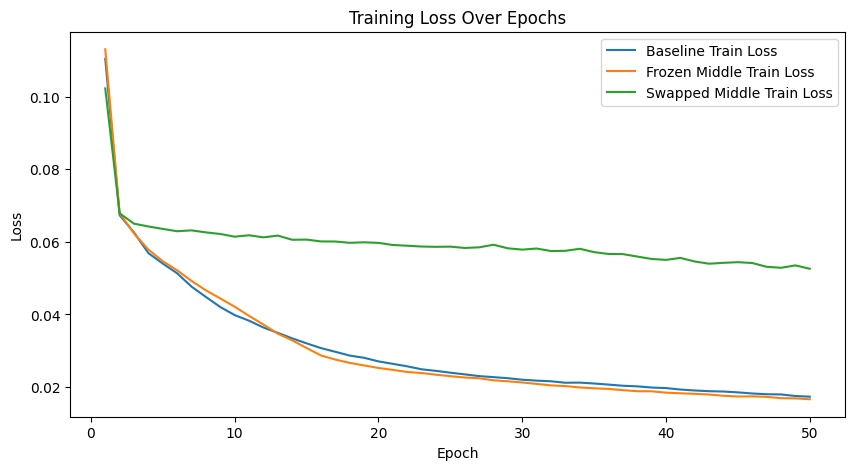

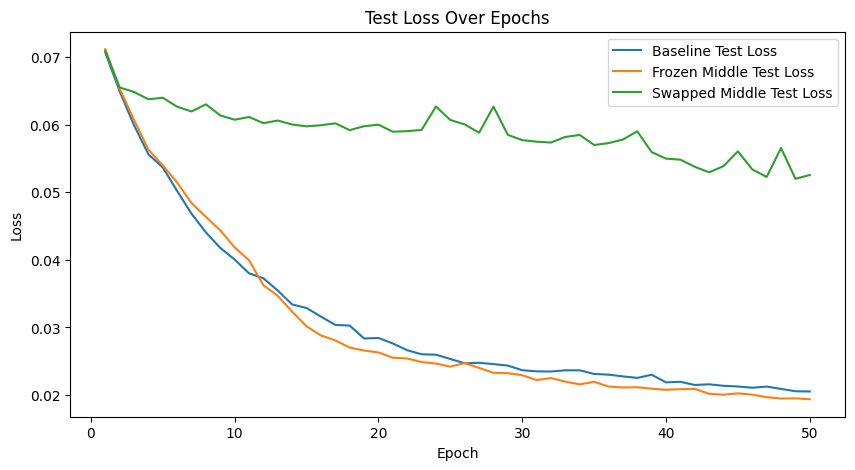

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import random
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Configurable Parameters
# ============================
seed = 42
use_subset = True  # Use a subset of the MNIST dataset for faster training
subset_size = 10000  # Size of the subset (for faster training)
batch_size = 256
epochs = 50  # Number of epochs
learning_rate = 1e-3

input_size = 28 * 28  # MNIST image size (28x28 flattened)
hidden_sizes_encoder = [512, 256, 128]  # Encoder hidden layers
latent_size = 64  # Latent size (middle layer size)
hidden_sizes_decoder = [128, 256, 512]  # Decoder hidden layers
output_size = 28 * 28  # Output size (same as input for autoencoder)
num_middle_layers = 100  # Number of frozen middle layers (used in swapped mode)
# ============================

# Set random seed for reproducibility
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset preparation
class GpuDataset(Dataset):
    def __init__(self, dataset):
        # Check if dataset is a Subset, and access the underlying dataset's data
        if isinstance(dataset, Subset):
            self.data = dataset.dataset.data[dataset.indices].float() / 255.0  # Normalize and select subset
        else:
            self.data = dataset.data.float() / 255.0  # Use full dataset
        
        self.data = self.data.view(-1, 28 * 28).to(device)  # Flatten the images and move to GPU
        self.length = self.data.shape[0]  # Set the length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx]

# Define transformation (not strictly necessary since we handle normalization)
transform = transforms.ToTensor()

# Load the MNIST training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Use a subset for faster training
if use_subset:
    train_dataset = Subset(train_dataset, range(subset_size))

# Wrap the datasets with GpuDataset to load data onto GPU
train_gpu_dataset = GpuDataset(train_dataset)
test_gpu_dataset = GpuDataset(test_dataset)

# Create DataLoaders
train_loader = DataLoader(train_gpu_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_gpu_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder definition
class CustomAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_sizes_encoder=[512, 256, 128],
                 latent_size=64, hidden_sizes_decoder=[128, 256, 512],
                 output_size=784, num_middle_layers=1, mode='baseline'):
        super(CustomAutoencoder, self).__init__()
        
        self.mode = mode
        self.num_middle_layers = num_middle_layers
        
        # Encoder
        encoder_layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes_encoder:
            encoder_layers.append(nn.Linear(prev_size, hidden_size).to(device))  # Move to GPU
            encoder_layers.append(nn.ReLU().to(device))  # Move to GPU
            prev_size = hidden_size
        encoder_layers.append(nn.Linear(prev_size, latent_size).to(device))  # Move to GPU
        encoder_layers.append(nn.ReLU().to(device))  # Move to GPU
        self.encoder = nn.Sequential(*encoder_layers).to(device)
        
        # Middle layers
        if mode == 'swapped':
            self.middle_layers = nn.ModuleList()
            for _ in range(num_middle_layers):
                middle_layer = nn.Linear(latent_size, latent_size).to(device)  # Move to GPU
                nn.init.normal_(middle_layer.weight)
                nn.init.normal_(middle_layer.bias)
                for param in middle_layer.parameters():
                    param.requires_grad = False
                self.middle_layers.append(middle_layer)
        else:
            self.middle = nn.Linear(latent_size, latent_size).to(device)  # Move to GPU
            if mode == 'frozen':
                for param in self.middle.parameters():
                    param.requires_grad = False
        
        # Decoder
        decoder_layers = []
        prev_size = latent_size
        for hidden_size in hidden_sizes_decoder:
            decoder_layers.append(nn.Linear(prev_size, hidden_size).to(device))  # Move to GPU
            decoder_layers.append(nn.ReLU().to(device))  # Move to GPU
            prev_size = hidden_size
        decoder_layers.append(nn.Linear(prev_size, output_size).to(device))  # Move to GPU
        decoder_layers.append(nn.Sigmoid().to(device))  # Move to GPU
        self.decoder = nn.Sequential(*decoder_layers).to(device)
        
    def forward(self, x, middle_layer_idx=None):
        encoded = self.encoder(x)
        if self.mode == 'swapped':
            if middle_layer_idx is None:
                middle = self.middle_layers[0](encoded)
            else:
                middle = self.middle_layers[middle_layer_idx](encoded)
        else:
            middle = self.middle(encoded)
        decoded = self.decoder(middle)
        return decoded

# Baseline training (all layers trainable)
def train_baseline():
    model = CustomAutoencoder(input_size, hidden_sizes_encoder, latent_size,
                              hidden_sizes_decoder, output_size, mode='baseline').to(device)
    criterion = nn.MSELoss().to(device)  # Move criterion to GPU
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, test_losses = [], []
    
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            inputs = batch  # Already on GPU
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                inputs = batch
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item() * inputs.size(0)
        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
    
    return train_losses, test_losses

# Training with a frozen middle layer
def train_frozen_middle():
    model = CustomAutoencoder(input_size, hidden_sizes_encoder, latent_size,
                              hidden_sizes_decoder, output_size, mode='frozen').to(device)
    criterion = nn.MSELoss().to(device)  # Move criterion to GPU
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    train_losses, test_losses = [], []
    
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            inputs = batch  # Already on GPU
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                inputs = batch  # Already on GPU
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item() * inputs.size(0)
        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
    
    return train_losses, test_losses

# Training with swapped frozen middle layers
def train_swapped_middle():
    model = CustomAutoencoder(input_size, hidden_sizes_encoder, latent_size,
                              hidden_sizes_decoder, output_size, num_middle_layers=num_middle_layers, mode='swapped').to(device)
    criterion = nn.MSELoss().to(device)  # Move criterion to GPU
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    train_losses, test_losses = [], []
    
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            inputs = batch  # Already on GPU
            middle_layer_idx = random.randint(0, num_middle_layers - 1)
            outputs = model(inputs, middle_layer_idx=middle_layer_idx)
            loss = criterion(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                inputs = batch  # Already on GPU
                outputs = model(inputs, middle_layer_idx=0)  # Arbitrarily choose first middle layer for eval
                loss = criterion(outputs, inputs)
                test_loss += loss.item() * inputs.size(0)
        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
    
    return train_losses, test_losses

# Main training process
if __name__ == "__main__":
    # Phase 1: Baseline Autoencoder
    baseline_train_losses, baseline_test_losses = train_baseline()
    
    # Phase 2: Autoencoder with Frozen Middle Layer
    frozen_train_losses, frozen_test_losses = train_frozen_middle()
    
    # Phase 3: Autoencoder with Swapped Frozen Middle Layers
    swapped_train_losses, swapped_test_losses = train_swapped_middle()
    
    # Visualization of Results
    epochs_range = range(1, epochs + 1)

    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, baseline_train_losses, label='Baseline Train Loss')
    plt.plot(epochs_range, frozen_train_losses, label='Frozen Middle Train Loss')
    plt.plot(epochs_range, swapped_train_losses, label='Swapped Middle Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

    # Plot test losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, baseline_test_losses, label='Baseline Test Loss')
    plt.plot(epochs_range, frozen_test_losses, label='Frozen Middle Test Loss')
    plt.plot(epochs_range, swapped_test_losses, label='Swapped Middle Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss Over Epochs')
    plt.legend()
    plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the target network with frozen weights
class TargetNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TargetNetwork, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        # Freeze the weights
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# Define the copying model
class CopyingModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CopyingModel, self).__init__()
        # These parameters will attempt to match the target weights and biases
        self.weights = nn.Parameter(torch.randn(hidden_size, input_size))
        self.biases = nn.Parameter(torch.randn(hidden_size, 1))

    def forward(self, x):
        # Linear transformation
        x = x.mm(self.weights.t()) + self.biases.t()
        return torch.sigmoid(x)

# Parameters
input_size = 5  # For example
hidden_size = 10
num_samples = 1000
learning_rate = 0.01
num_epochs = 500

# Generate random inputs
X = torch.randn(num_samples, input_size)

# Instantiate the target network
target_net = TargetNetwork(input_size, hidden_size)
with torch.no_grad():
    # Compute target activations
    Y = target_net(X)

# Instantiate the copying model
copy_net = CopyingModel(input_size, hidden_size)

# Define the optimizer
optimizer = optim.Adam(copy_net.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = copy_net(X)
    loss = nn.MSELoss()(outputs, Y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate weight matching
with torch.no_grad():
    target_weights = target_net.fc.weight
    target_biases = target_net.fc.bias
    estimated_weights = copy_net.weights
    estimated_biases = copy_net.biases.squeeze()

    weight_error = nn.MSELoss()(estimated_weights, target_weights)
    bias_error = nn.MSELoss()(estimated_biases, target_biases)

    print(f'Weight MSE: {weight_error.item():.6f}')
    print(f'Bias MSE: {bias_error.item():.6f}')


Epoch [100/500], Loss: 0.0473
Epoch [200/500], Loss: 0.0020
Epoch [300/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000
Weight MSE: 0.000000
Bias MSE: 0.000000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
torch.manual_seed(42)

# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Linear activation function
def activation_function(x):
    return x  # Identity function

# Estimator Model
class EstimatorModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_pairs):
        super(EstimatorModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_pairs = num_pairs  # Number of input-output pairs per sample

        # Encoder for aggregated residuals
        self.encoder = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2)  # Optional: Dropout for regularization
        )
        # Update networks for weights and biases
        self.update_W = nn.Linear(128, hidden_size * input_size)
        self.update_b = nn.Linear(128, hidden_size)
    
    def forward(self, X, Y, hat_W, hat_b):
        """
        X: (batch_size, M, input_size)
        Y: (batch_size, M, hidden_size)
        hat_W: (batch_size, hidden_size, input_size)
        hat_b: (batch_size, hidden_size, 1)
        """
        batch_size, M, input_size = X.size()
        hidden_size = hat_W.size(1)

        # Compute predicted Y
        Y_hat = torch.bmm(hat_W, X.transpose(1, 2)) + hat_b  # (batch_size, hidden_size, num_pairs)
        Y_hat = Y_hat.transpose(1, 2)  # (batch_size, num_pairs, hidden_size)

        # Compute residuals
        delta_Y = Y - Y_hat  # (batch_size, num_pairs, hidden_size)

        # Aggregate residuals by averaging over M
        delta_Y_avg = delta_Y.mean(dim=1)  # (batch_size, hidden_size)

        # Encode the aggregated residuals
        features = self.encoder(delta_Y_avg)  # (batch_size, 128)

        # Predict updates
        delta_W = self.update_W(features).view(batch_size, hidden_size, input_size)  # (batch_size, hidden_size, input_size)
        delta_b = self.update_b(features).view(batch_size, hidden_size, 1)  # (batch_size, hidden_size, 1)

        return delta_W, delta_b

# Custom Dataset that Pre-loads Everything on the GPU
class WeightInferenceDatasetGPU:
    def __init__(self, num_samples, input_size, hidden_size, num_pairs, test_split=0.1):
        super(WeightInferenceDatasetGPU, self).__init__()
        self.num_samples = num_samples
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_pairs = num_pairs
        split_idx = int((1 - test_split) * num_samples)

        # Generate random weights and biases for each sample and move to GPU
        W_all = torch.randn(num_samples, hidden_size, input_size, device=device)
        b_all = torch.randn(num_samples, hidden_size, 1, device=device)
        # Generate random inputs and move to GPU
        X_all = torch.randn(num_samples, num_pairs, input_size, device=device)
        # Compute outputs and move to GPU
        # Y_all = activation_function(W x + b)
        Y_all = torch.bmm(W_all, X_all.transpose(1, 2)) + b_all  # (num_samples, hidden_size, num_pairs)
        Y_all = Y_all.transpose(1, 2)  # (num_samples, num_pairs, hidden_size)
        Y_all = activation_function(Y_all)  # Linear activation

        # Split the dataset into train and test
        self.X_train, self.Y_train, self.W_train, self.b_train = X_all[:split_idx], Y_all[:split_idx], W_all[:split_idx], b_all[:split_idx]
        self.X_test, self.Y_test, self.W_test, self.b_test = X_all[split_idx:], Y_all[split_idx:], W_all[split_idx:], b_all[split_idx:]
    
    def get_train_data(self):
        return self.X_train, self.Y_train, self.W_train, self.b_train
    
    def get_test_data(self):
        return self.X_test, self.Y_test, self.W_test, self.b_test

# Accuracy Calculation
def calculate_accuracy(predicted, actual, tolerance=1e-2):
    correct = (torch.abs(predicted - actual) < tolerance).float()
    accuracy = 100.0 * correct.mean().item()
    return accuracy

# Training Parameters
input_size = 5
hidden_size = 10
num_samples = 10000  # Number of samples
num_pairs = 100  # Number of input-output pairs per sample
num_epochs = 5000
T = 20  # Number of refinement steps
learning_rate = 0.001
test_split = 0.1

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/weight_inference')

# Create Dataset and move everything to GPU at once
dataset_gpu = WeightInferenceDatasetGPU(num_samples, input_size, hidden_size, num_pairs, test_split=test_split)

# Get train and test data
X_train, Y_train, W_train, b_train = dataset_gpu.get_train_data()
X_test, Y_test, W_test, b_test = dataset_gpu.get_test_data()

# Initialize Estimator Model and move to GPU
estimator_model = EstimatorModel(input_size, hidden_size, num_pairs).to(device)
estimator_model.train()

# Define Optimizer and Loss Function
optimizer = optim.Adam(estimator_model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)  # Learning rate scheduler
criterion = nn.MSELoss()

# Training Loop
for epoch in range(num_epochs):
    estimator_model.train()
    optimizer.zero_grad()

    # Initialize estimates with zeros (consistent initialization)
    batch_size = X_train.size(0)
    hat_W = torch.zeros(batch_size, hidden_size, input_size, device=device)
    hat_b = torch.zeros(batch_size, hidden_size, 1, device=device)
    
    # Forward pass through T refinement steps
    for t in range(T):
        # Compute predicted outputs with current estimates
        Y_hat = torch.bmm(hat_W, X_train.transpose(1, 2)) + hat_b  # (batch_size, hidden_size, num_pairs)
        Y_hat = activation_function(Y_hat)  # Linear activation

        # Compute discrepancy between true and predicted outputs
        delta_Y = Y_train - Y_hat.transpose(1, 2)  # (batch_size, num_pairs, hidden_size)

        # Predict updates (now including current estimates)
        delta_W, delta_b = estimator_model(X_train, Y_train, hat_W, hat_b)

        # Update estimates
        hat_W = hat_W + delta_W
        hat_b = hat_b + delta_b

    # Compute loss between final estimates and true parameters
    loss_W = criterion(hat_W, W_train)  # Shape: scalar
    loss_b = criterion(hat_b.squeeze(2), b_train.squeeze(2))  # Shape: scalar
    loss = loss_W + loss_b

    loss.backward()
    torch.nn.utils.clip_grad_norm_(estimator_model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    scheduler.step()

    # Evaluate test accuracy every 100 epochs to save computation
    if (epoch + 1) % 100 == 0 or epoch == 0:
        estimator_model.eval()
        with torch.no_grad():
            batch_size_test = X_test.size(0)
            hat_W_test = torch.zeros(batch_size_test, hidden_size, input_size, device=device)
            hat_b_test = torch.zeros(batch_size_test, hidden_size, 1, device=device)

            for t in range(T):
                Y_hat_test = torch.bmm(hat_W_test, X_test.transpose(1, 2)) + hat_b_test  # (batch_size, hidden_size, num_pairs)
                Y_hat_test = activation_function(Y_hat_test)  # Linear activation
                delta_Y_test = Y_test - Y_hat_test.transpose(1, 2)  # (batch_size, num_pairs, hidden_size)
                delta_W_test, delta_b_test = estimator_model(X_test, Y_test, hat_W_test, hat_b_test)
                hat_W_test = hat_W_test + delta_W_test
                hat_b_test = hat_b_test + delta_b_test

            # Calculate loss for test set
            test_loss_W = criterion(hat_W_test, W_test)
            test_loss_b = criterion(hat_b_test.squeeze(2), b_test.squeeze(2))
            test_loss = test_loss_W + test_loss_b

            # Calculate accuracy (matching weights and biases)
            accuracy_W = calculate_accuracy(hat_W_test, W_test)
            accuracy_b = calculate_accuracy(hat_b_test, b_test)
            overall_accuracy = (accuracy_W + accuracy_b) / 2.0

        # Log to TensorBoard
        writer.add_scalar('Train/Loss', loss.item(), epoch+1)
        writer.add_scalar('Test/Loss', test_loss.item(), epoch+1)
        writer.add_scalar('Test/Accuracy', overall_accuracy, epoch+1)

        # Print loss and accuracy on the same line
        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}, Accuracy: {overall_accuracy:.2f}%')

# Close TensorBoard writer
writer.close()

print("Training Completed.")

# Final Evaluation on the Test Set (Inference on unseen data)
def final_inference_and_evaluate(estimator_model, X_test, Y_test, W_test, b_test, T=10):
    estimator_model.eval()
    with torch.no_grad():
        batch_size_test = X_test.size(0)
        hat_W_test = torch.zeros(batch_size_test, hidden_size, input_size, device=device)
        hat_b_test = torch.zeros(batch_size_test, hidden_size, 1, device=device)

        for t in range(T):
            Y_hat_test = torch.bmm(hat_W_test, X_test.transpose(1, 2)) + hat_b_test  # (batch_size, hidden_size, num_pairs)
            Y_hat_test = activation_function(Y_hat_test)  # Linear activation
            delta_Y_test = Y_test - Y_hat_test.transpose(1, 2)  # (batch_size, num_pairs, hidden_size)
            delta_W_test, delta_b_test = estimator_model(X_test, Y_test, hat_W_test, hat_b_test)
            hat_W_test = hat_W_test + delta_W_test
            hat_b_test = hat_b_test + delta_b_test

        # Calculate final accuracy
        final_accuracy_W = calculate_accuracy(hat_W_test, W_test)
        final_accuracy_b = calculate_accuracy(hat_b_test, b_test)
        final_accuracy = (final_accuracy_W + final_accuracy_b) / 2.0

        print(f'Final Accuracy on Test Set: {final_accuracy:.2f}%')

# Perform final evaluation
final_inference_and_evaluate(estimator_model, X_test, Y_test, W_test, b_test, T=10)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
torch.manual_seed(42)

# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Linear activation function
def activation_function(x):
    return x  # Identity function for linear activation

# Estimator Model with Batch Normalization and Increased Capacity
class EstimatorModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_pairs, num_probe_pairs):
        super(EstimatorModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_pairs = num_pairs
        self.num_probe_pairs = num_probe_pairs  # Number of probing input-output pairs

        # Encoder for main residuals
        self.encoder_main = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        # Encoder for probing residuals
        self.encoder_probe = nn.Sequential(
            nn.Linear(num_probe_pairs * (input_size + hidden_size), 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        # Combined fully connected layers
        self.fc_combined = nn.Sequential(
            nn.Linear(256 + 256 + hidden_size * input_size + hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        # Update networks for weights and biases
        self.update_W = nn.Sequential(
            nn.Linear(256, hidden_size * input_size),
            nn.Tanh()  # To bound the updates
        )
        self.update_b = nn.Sequential(
            nn.Linear(256, hidden_size),
            nn.Tanh()
        )

    def forward(self, X_main, Y_main, X_probe, Y_probe, hat_W, hat_b):
        """
        X_main: (batch_size, M, input_size)
        Y_main: (batch_size, M, hidden_size)
        X_probe: (batch_size, K, input_size)
        Y_probe: (batch_size, K, hidden_size)
        hat_W: (batch_size, hidden_size, input_size)
        hat_b: (batch_size, hidden_size, 1)
        """
        batch_size = X_main.size(0)
        M = self.num_pairs
        K = self.num_probe_pairs

        # Compute predicted Y_main
        Y_hat_main = torch.bmm(hat_W, X_main.transpose(1, 2)) + hat_b  # (batch_size, hidden_size, M)
        Y_hat_main = activation_function(Y_hat_main)  # Linear activation
        Y_hat_main = Y_hat_main.transpose(1, 2)  # (batch_size, M, hidden_size)

        # Compute residuals for main inputs
        delta_Y_main = Y_main - Y_hat_main  # (batch_size, M, hidden_size)

        # Aggregate residuals by averaging over M
        delta_Y_main_avg = delta_Y_main.mean(dim=1)  # (batch_size, hidden_size)

        # Encode the aggregated residuals from main inputs
        features_main = self.encoder_main(delta_Y_main_avg)  # (batch_size, 256)

        # Flatten and concatenate X_probe and Y_probe
        probe_features = torch.cat([X_probe, Y_probe], dim=2).view(batch_size, -1)  # (batch_size, K*(input_size + hidden_size))

        # Encode the direct probing input-output pairs
        features_probe = self.encoder_probe(probe_features)  # (batch_size, 256)

        # Flatten current estimates
        hat_W_flat = hat_W.view(batch_size, -1)  # (batch_size, hidden_size * input_size)
        hat_b_flat = hat_b.view(batch_size, -1)  # (batch_size, hidden_size)

        # Combine all features
        combined_features = torch.cat([features_main, features_probe, hat_W_flat, hat_b_flat], dim=1)  # (batch_size, 256 + 256 + 50 + 10 = 572)

        # Process combined features
        features_combined = self.fc_combined(combined_features)  # (batch_size, 256)

        # Predict updates
        delta_W = self.update_W(features_combined).view(batch_size, self.hidden_size, self.input_size)  # (batch_size, hidden_size, input_size)
        delta_b = self.update_b(features_combined).view(batch_size, self.hidden_size, 1)  # (batch_size, hidden_size, 1)

        return delta_W, delta_b

# Custom Dataset that Pre-loads Everything on the GPU
class WeightInferenceDatasetGPU:
    def __init__(self, num_samples, input_size, hidden_size, num_pairs, num_probe_pairs, test_split=0.1):
        super(WeightInferenceDatasetGPU, self).__init__()
        self.num_samples = num_samples
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_pairs = num_pairs
        self.num_probe_pairs = num_probe_pairs
        split_idx = int((1 - test_split) * num_samples)

        # Generate random weights and biases for each sample and move to GPU
        W_all = torch.randn(num_samples, hidden_size, input_size, device=device)
        b_all = torch.randn(num_samples, hidden_size, 1, device=device)

        # Generate random main inputs and move to GPU
        X_main_all = torch.randn(num_samples, num_pairs, input_size, device=device)
        # Compute main outputs and move to GPU
        Y_main_all = torch.bmm(W_all, X_main_all.transpose(1, 2)) + b_all  # (num_samples, hidden_size, num_pairs)
        Y_main_all = Y_main_all.transpose(1, 2)  # (num_samples, num_pairs, hidden_size)
        Y_main_all = activation_function(Y_main_all)  # Linear activation

        # Generate probing inputs (could be the same or different distribution)
        X_probe_all = torch.randn(num_samples, num_probe_pairs, input_size, device=device)
        # Compute probing outputs
        Y_probe_all = torch.bmm(W_all, X_probe_all.transpose(1, 2)) + b_all  # (num_samples, hidden_size, num_probe_pairs)
        Y_probe_all = Y_probe_all.transpose(1, 2)  # (num_samples, num_probe_pairs, hidden_size)
        Y_probe_all = activation_function(Y_probe_all)  # Linear activation

        # Split the dataset into train and test
        self.X_main_train = X_main_all[:split_idx]
        self.Y_main_train = Y_main_all[:split_idx]
        self.X_probe_train = X_probe_all[:split_idx]
        self.Y_probe_train = Y_probe_all[:split_idx]
        self.W_train = W_all[:split_idx]
        self.b_train = b_all[:split_idx]

        self.X_main_test = X_main_all[split_idx:]
        self.Y_main_test = Y_main_all[split_idx:]
        self.X_probe_test = X_probe_all[split_idx:]
        self.Y_probe_test = Y_probe_all[split_idx:]
        self.W_test = W_all[split_idx:]
        self.b_test = b_all[split_idx:]

    def get_train_data(self):
        return (self.X_main_train, self.Y_main_train, self.X_probe_train, self.Y_probe_train, self.W_train, self.b_train)

    def get_test_data(self):
        return (self.X_main_test, self.Y_main_test, self.X_probe_test, self.Y_probe_test, self.W_test, self.b_test)

# Accuracy Calculation
def calculate_accuracy(predicted, actual, tolerance=1e-2):
    correct = (torch.abs(predicted - actual) < tolerance).float()
    accuracy = 100.0 * correct.mean().item()
    return accuracy

# Training Parameters
input_size = 5
hidden_size = 10
num_samples = 20000  # Increased number of samples to improve generalization
num_pairs = 100  # Number of main input-output pairs per sample
num_probe_pairs = 10  # Number of probing input-output pairs per sample
num_epochs = 5000
T = 20  # Number of refinement steps
learning_rate = 0.001
test_split = 0.1
tolerance = 1e-2

# Initialize TensorBoard writer (optional)
# writer = SummaryWriter(log_dir='runs/weight_inference_combined')

# Create Dataset and move everything to GPU at once
dataset_gpu = WeightInferenceDatasetGPU(num_samples, input_size, hidden_size, num_pairs, num_probe_pairs, test_split=test_split)

# Get train and test data
(X_main_train, Y_main_train, X_probe_train, Y_probe_train, W_train, b_train) = dataset_gpu.get_train_data()
(X_main_test, Y_main_test, X_probe_test, Y_probe_test, W_test, b_test) = dataset_gpu.get_test_data()

# Initialize Estimator Model and move to GPU
estimator_model = EstimatorModel(input_size, hidden_size, num_pairs, num_probe_pairs).to(device)
estimator_model.train()

# Define Optimizer and Loss Function
optimizer = optim.Adam(estimator_model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Increased weight_decay for stronger regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)  # Learning rate scheduler
criterion = nn.MSELoss()

# Early Stopping Parameters
early_stopping_patience = 500  # Number of epochs to wait before stopping if no improvement
best_test_loss = float('inf')
epochs_no_improve = 0

# Training Loop
for epoch in range(num_epochs):
    estimator_model.train()
    optimizer.zero_grad()

    # Initialize estimates with zeros (consistent initialization)
    batch_size = X_main_train.size(0)
    hat_W = torch.zeros(batch_size, hidden_size, input_size, device=device)
    hat_b = torch.zeros(batch_size, hidden_size, 1, device=device)

    # Forward pass through T refinement steps
    for t in range(T):
        # Compute predicted outputs with current estimates for main inputs
        Y_hat_main = torch.bmm(hat_W, X_main_train.transpose(1, 2)) + hat_b  # (batch_size, hidden_size, num_pairs)
        Y_hat_main = activation_function(Y_hat_main)  # Linear activation
        Y_hat_main = Y_hat_main.transpose(1, 2)  # (batch_size, num_pairs, hidden_size)

        # Compute residuals for main inputs
        delta_Y_main = Y_main_train - Y_hat_main  # (batch_size, num_pairs, hidden_size)
        # Aggregate residuals by averaging over M
        delta_Y_main_avg = delta_Y_main.mean(dim=1)  # (batch_size, hidden_size)

        # Compute predicted outputs with current estimates for probing inputs
        Y_hat_probe = torch.bmm(hat_W, X_probe_train.transpose(1, 2)) + hat_b  # (batch_size, hidden_size, num_probe_pairs)
        Y_hat_probe = activation_function(Y_hat_probe)  # Linear activation
        Y_hat_probe = Y_hat_probe.transpose(1, 2)  # (batch_size, num_probe_pairs, hidden_size)

        # Compute residuals for probing inputs
        delta_Y_probe = Y_probe_train - Y_hat_probe  # (batch_size, num_probe_pairs, hidden_size)
        # Aggregate residuals by averaging over K
        delta_Y_probe_avg = delta_Y_probe.mean(dim=1)  # (batch_size, hidden_size)

        # Predict updates (combining both methods)
        delta_W, delta_b = estimator_model(
            X_main_train, Y_main_train, X_probe_train, Y_probe_train, hat_W, hat_b
        )

        # Update estimates
        hat_W = hat_W + delta_W
        hat_b = hat_b + delta_b

    # Compute loss between final estimates and true parameters
    loss_W = criterion(hat_W, W_train)  # Shape: scalar
    loss_b = criterion(hat_b.squeeze(2), b_train.squeeze(2))  # Shape: scalar
    loss = loss_W + loss_b

    loss.backward()
    torch.nn.utils.clip_grad_norm_(estimator_model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    scheduler.step()

    # Evaluate test accuracy every 100 epochs to save computation
    if (epoch + 1) % 100 == 0 or epoch == 0:
        estimator_model.eval()
        with torch.no_grad():
            batch_size_test = X_main_test.size(0)
            hat_W_test = torch.zeros(batch_size_test, hidden_size, input_size, device=device)
            hat_b_test = torch.zeros(batch_size_test, hidden_size, 1, device=device)

            # Forward pass through T refinement steps for test data
            for t in range(T):
                # Compute predicted outputs with current estimates for main inputs
                Y_hat_main_test = torch.bmm(hat_W_test, X_main_test.transpose(1, 2)) + hat_b_test  # (batch_size, hidden_size, num_pairs)
                Y_hat_main_test = activation_function(Y_hat_main_test)  # Linear activation
                Y_hat_main_test = Y_hat_main_test.transpose(1, 2)  # (batch_size, num_pairs, hidden_size)

                # Compute residuals for main inputs
                delta_Y_main_test = Y_main_test - Y_hat_main_test  # (batch_size, num_pairs, hidden_size)
                delta_Y_main_test_avg = delta_Y_main_test.mean(dim=1)  # (batch_size, hidden_size)

                # Compute predicted outputs with current estimates for probing inputs
                Y_hat_probe_test = torch.bmm(hat_W_test, X_probe_test.transpose(1, 2)) + hat_b_test  # (batch_size, hidden_size, num_probe_pairs)
                Y_hat_probe_test = activation_function(Y_hat_probe_test)  # Linear activation
                Y_hat_probe_test = Y_hat_probe_test.transpose(1, 2)  # (batch_size, num_probe_pairs, hidden_size)

                # Compute residuals for probing inputs
                delta_Y_probe_test = Y_probe_test - Y_hat_probe_test  # (batch_size, num_probe_pairs, hidden_size)
                delta_Y_probe_test_avg = delta_Y_probe_test.mean(dim=1)  # (batch_size, hidden_size)

                # Predict updates (combining both methods)
                delta_W_test, delta_b_test = estimator_model(
                    X_main_test, Y_main_test, X_probe_test, Y_probe_test, hat_W_test, hat_b_test
                )

                # Update estimates
                hat_W_test = hat_W_test + delta_W_test
                hat_b_test = hat_b_test + delta_b_test

            # Calculate loss for test set
            test_loss_W = criterion(hat_W_test, W_test)
            test_loss_b = criterion(hat_b_test.squeeze(2), b_test.squeeze(2))
            test_loss = test_loss_W + test_loss_b

            # Calculate accuracy (matching weights and biases)
            accuracy_W = calculate_accuracy(hat_W_test, W_test, tolerance)
            accuracy_b = calculate_accuracy(hat_b_test, b_test, tolerance)
            overall_accuracy = (accuracy_W + accuracy_b) / 2.0

            # Check for early stopping
            if test_loss.item() < best_test_loss:
                best_test_loss = test_loss.item()
                epochs_no_improve = 0
                # Optionally, save the model
                # torch.save(estimator_model.state_dict(), 'best_estimator_model.pth')
            else:
                epochs_no_improve += 100
                if epochs_no_improve >= early_stopping_patience:
                    print(f'Early stopping triggered after {epoch+1} epochs.')
                    break

        # Log to TensorBoard (optional)
        # writer.add_scalar('Train/Loss', loss.item(), epoch+1)
        # writer.add_scalar('Test/Loss', test_loss.item(), epoch+1)
        # writer.add_scalar('Test/Accuracy', overall_accuracy, epoch+1)

        # Print loss and accuracy on the same line
        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}, Accuracy: {overall_accuracy:.2f}%')

# Close TensorBoard writer if used
# writer.close()

print("Training Completed.")

# Final Evaluation on the Test Set (Inference on unseen data)
def final_inference_and_evaluate(estimator_model, X_main_test, Y_main_test, X_probe_test, Y_probe_test, W_test, b_test, T=20):
    estimator_model.eval()
    with torch.no_grad():
        batch_size_test = X_main_test.size(0)
        hat_W_test = torch.zeros(batch_size_test, hidden_size, input_size, device=device)
        hat_b_test = torch.zeros(batch_size_test, hidden_size, 1, device=device)

        # Forward pass through T refinement steps for test data
        for t in range(T):
            # Compute predicted outputs with current estimates for main inputs
            Y_hat_main_test = torch.bmm(hat_W_test, X_main_test.transpose(1, 2)) + hat_b_test  # (batch_size, hidden_size, num_pairs)
            Y_hat_main_test = activation_function(Y_hat_main_test)  # Linear activation
            Y_hat_main_test = Y_hat_main_test.transpose(1, 2)  # (batch_size, num_pairs, hidden_size)

            # Compute residuals for main inputs
            delta_Y_main_test = Y_main_test - Y_hat_main_test  # (batch_size, num_pairs, hidden_size)
            delta_Y_main_test_avg = delta_Y_main_test.mean(dim=1)  # (batch_size, hidden_size)

            # Compute predicted outputs with current estimates for probing inputs
            Y_hat_probe_test = torch.bmm(hat_W_test, X_probe_test.transpose(1, 2)) + hat_b_test  # (batch_size, hidden_size, num_probe_pairs)
            Y_hat_probe_test = activation_function(Y_hat_probe_test)  # Linear activation
            Y_hat_probe_test = Y_hat_probe_test.transpose(1, 2)  # (batch_size, num_probe_pairs, hidden_size)

            # Compute residuals for probing inputs
            delta_Y_probe_test = Y_probe_test - Y_hat_probe_test  # (batch_size, num_probe_pairs, hidden_size)
            delta_Y_probe_test_avg = delta_Y_probe_test.mean(dim=1)  # (batch_size, hidden_size)

            # Predict updates (combining both methods)
            delta_W_test, delta_b_test = estimator_model(
                X_main_test, Y_main_test, X_probe_test, Y_probe_test, hat_W_test, hat_b_test
            )

            # Update estimates
            hat_W_test = hat_W_test + delta_W_test
            hat_b_test = hat_b_test + delta_b_test

        # Calculate final accuracy
        final_accuracy_W = calculate_accuracy(hat_W_test, W_test, tolerance)
        final_accuracy_b = calculate_accuracy(hat_b_test, b_test, tolerance)
        final_accuracy = (final_accuracy_W + final_accuracy_b) / 2.0

        print(f'Final Accuracy on Test Set: {final_accuracy:.2f}%')

# Perform final evaluation
final_inference_and_evaluate(estimator_model, X_main_test, Y_main_test, X_probe_test, Y_probe_test, W_test, b_test, T=T)
